根据薛定谔方程，拉普拉斯算符 $\nabla^2$ 作用于一维波函数 $\Psi$ 上

$$(-\frac{1}{2}\nabla^2 + \nu_{pot})\Psi = E\Psi$$

$$\nabla^2 = \frac{\delta^2\Psi}{\delta x^2} $$

采用有限差分

$$\nabla^2_i = \frac{\Psi_{i-1}+\Psi_{i+1} - 2\Psi{i}}{\delta x^2} $$

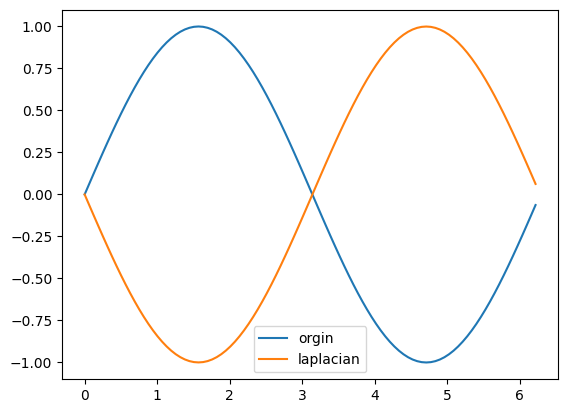

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def get_laplacian(psi, dx):
    '''直接对格点上的波函数值作差，考虑边界'''
    return (np.roll(psi, 1) + np.roll(psi, -1) - 2*psi)/dx**2

# TODO 为什么必须要用endpoint=False？
x, dx = np.linspace(0, 2*np.pi, 100, endpoint=False, retstep=True)
psi = np.sin(x) # 假设波函数为sin(x)
plt.plot(x, psi, label='orgin')
plt.plot(x, get_laplacian(psi, dx), label='laplacian')
plt.legend()
plt.show()

不同于第一个项目（初猜电荷密度），这个项目选择初猜波函数，而且先尝试了用python写自洽求解本征值问题

差值矢量定义为：

$$e = \hat{H}\Psi - E\Psi$$

迭代后的混合，采用：

$$\Psi_{new} = \Psi_{trial} + \alpha e$$

In [20]:
def get_potential(x):
    return np.cos(x)

def get_laplacian(psi, dx):
    return ((np.roll(psi, -1) + np.roll(psi, 1) - 2 * psi) / dx**2.)

def get_ham_psi(psi, x, dx):
    return (-0.5 * get_laplacian(psi, dx) + get_potential(x)*psi)

def get_energy(psi, x, dx):
    return np.dot(psi, get_ham_psi(psi, x, dx))

def get_residual(psi, x, dx): 
    return get_ham_psi(psi, x, dx) - get_energy(psi, x, dx)*psi

def update_psi(psi, x, dx, alpha):
    '''注意alpha并没有再乘以老的波函数'''
    return normalize(psi + alpha * get_residual(psi, x, dx))

def normalize(psi):
    return psi / np.linalg.norm(psi)

def sc_minimize(psi, x, dx, alpha=-0.001, threshold=1e-4, max_steps=20000):
    for i in range(max_steps):
        psi = update_psi(psi, x, dx, alpha)
        residual = get_residual(psi, x, dx)
        if np.linalg.norm(residual) < threshold:
            energy = get_energy(psi, x, dx)
            return psi, energy
    print (f"Failed to reach threshold within {max_steps} steps. Try either increasing steps or tweak alpha")


x, dx = np.linspace(0, 2*np.pi, 100, endpoint=True, retstep=True)
psi_trial = np.random.rand(x.size)
psi, E = sc_minimize(psi_trial, x, dx)

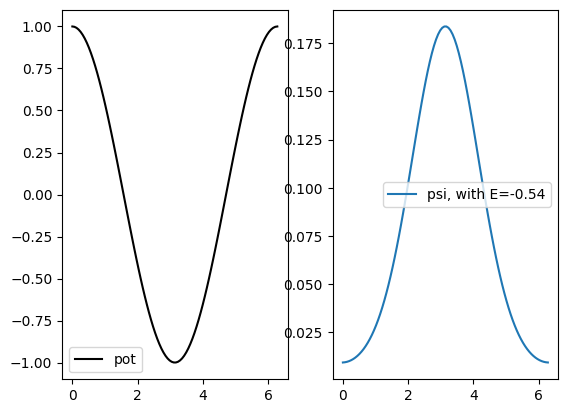

In [21]:
fig, axes = plt.subplots(1,2)
axes[0].plot(x, get_potential(x), color="black", label='pot')
axes[0].legend()
axes[1].plot(x, psi, label='psi, with E={:.2f}'.format(E))
axes[1].legend()

现在的问题在于，我们没有区分电子，如果前面的电子收敛到了基态，后面的电子如何才能收敛到次优解？

为此，我们必须正交化波函数，从而将已经解出来的更低能量本征态考虑在内

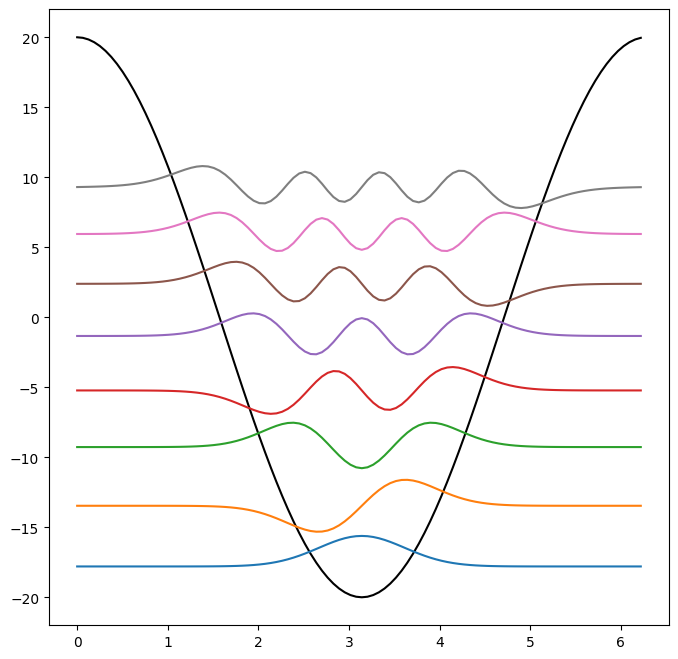

In [22]:
def get_potential(x):
    return 20*np.cos(x)

def get_laplacian(psi, dx):
    return ((np.roll(psi, -1) + np.roll(psi, 1) - 2 * psi) / dx**2.)

def get_ham_psi(psi, x, dx):
    return (-0.5 * get_laplacian(psi, dx) + get_potential(x)*psi)

def get_energy(psi, x, dx):
    return np.dot(psi, get_ham_psi(psi, x, dx))

def get_residual(psi, x, dx, eigenvectors): 
    # 正交化
    return orthogonalize(get_ham_psi(psi, x, dx) - get_energy(psi, x, dx)*psi, eigenvectors)

def update_psi(psi, x, dx, alpha, eigenvectors):
    # 正交化
    return normalize(orthogonalize(psi + alpha * get_residual(psi, x, dx, eigenvectors), eigenvectors))

def normalize(psi):
    return psi / np.linalg.norm(psi)

def orthogonalize(psi, eigenvectors): # 格拉姆-施密特正交化
    for ev in eigenvectors: # 基于投影原理
        psi -= np.dot(psi, ev) * ev
    return psi

def sc_minimize(psi, x, dx, eigenvectors, alpha=-0.001, threshold=1e-4, max_steps=20000):
    for i in range(max_steps):
        psi = update_psi(psi, x, dx, alpha, eigenvectors)
        residual = get_residual(psi, x, dx, eigenvectors)
        energy = get_energy(psi, x, dx)
        if np.linalg.norm(residual) < threshold:
            return psi, energy
    print (f"Failed to reach threshold within {max_steps} steps. Try either increasing max_steps or tweak alpha")
    return psi, energy

x, dx = np.linspace(0, 2*np.pi, 100, endpoint=False, retstep=True)
psi_trial = np.random.rand(x.size)
n_states = 8
scale = 8. # Just to see the waves more easily
eigenvectors, eigenvalues = [], []

for n in range(n_states):
    psi, E = sc_minimize(psi_trial, x, dx, eigenvectors)
    eigenvectors.append(psi)
    eigenvalues.append(E)
        
ax = plt.figure(figsize=(8, 8)).gca()
ax.plot(x, get_potential(x), color="black")
for n in range(n_states):
    ax.plot(x, eigenvectors[n] * scale + eigenvalues[n])

不考虑势场时求解体系本征值和本征态已经完成

为方便调用，把它们归类整理

In [23]:
class Schroedinger_1D:
    def __init__(self, x_max=2*np.pi, resolution=100, potential=np.cos, alpha=-0.001, scale=20, n_states=5, threshold=1e-5, max_steps=20000):
        self.resolution = resolution
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.potential = scale*potential(self.x)
        self.alpha = alpha
        self.n_states = n_states
        self.threshold = threshold
        self.max_steps = max_steps
        self.eigenvectors, self.eigenvalues = [], []
            
    def initialize_psi(self):
        return np.random.rand(self.x.size)
            
    def get_laplacian(self, psi):
        return (np.roll(psi, 1) + np.roll(psi, -1) - 2 * psi) / self.dx**2        

    def get_ham_psi(self, psi):
        return (-0.5 * self.get_laplacian(psi) + self.potential * psi)

    def get_energy(self, psi):
        return np.dot(psi, self.get_ham_psi(psi))

    def get_residual(self, psi): 
        return self.orthogonalize(self.get_ham_psi(psi) - self.get_energy(psi)*psi)

    def update_psi(self, psi):
        return normalize(self.orthogonalize(psi + self.alpha * self.get_residual(psi)))

    def normalize(psi):
        return psi / np.linalg.norm(psi)

    def orthogonalize(self, psi):
        for ev in self.eigenvectors:
            psi -= np.dot(psi, ev) * ev
        return psi

    def sc_minimize(self, psi):
        for i in range(self.max_steps):
            psi = self.update_psi(psi)
            residual = self.get_residual(psi)
            energy = self.get_energy(psi)
            if np.linalg.norm(residual) < self.threshold:
                return psi, energy
        print (f"Failed to reach threshold within {self.max_steps} steps. Residual is still {np.linalg.norm(residual)}. Try either increasing max_steps or tweak alpha")
        return psi, energy

    def converge_all_states(self):
        for n in range(self.n_states):
            psi = self.initialize_psi()
            psi, energy = self.sc_minimize(psi)
            self.eigenvectors.append(psi)
            self.eigenvalues.append(energy)
    
    def plot(self):
        ax = plt.figure(figsize=(8, 8)).gca()
        ax.plot(self.x, self.potential, 'k')
        for i in range(self.n_states):
            ax.plot(self.x, self.eigenvectors[i]*8 + self.eigenvalues[i])
        plt.show()

验证这个类确实可用

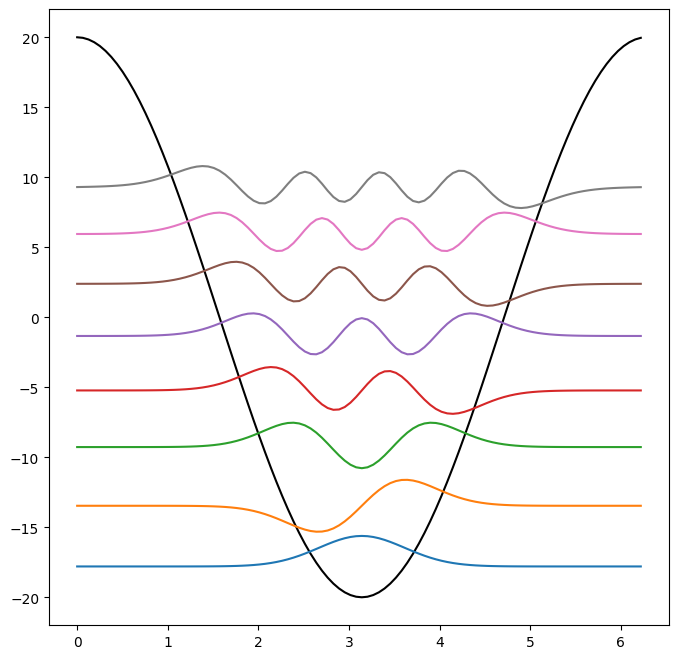

In [24]:
my_schroedinger = Schroedinger_1D(n_states=8)
my_schroedinger.converge_all_states()
my_schroedinger.plot()

### 用 `scipy` 加速

python源码的执行效率太低，不管初猜波函数给的是啥，最后都会收敛于本征态。

广义本征值这种线代常见问题，采用scipy内置的函数 `scipy.sparse.linalg.eigsh()` 完成即可，稳定且快速；

稀疏矩阵，还可进一步加速，调用 `scipy.sparse.linalg.LinearOperator` 将 $\hat{H}\Psi$ 转成稀疏矩阵即可

In [25]:
from scipy.sparse.linalg import LinearOperator, eigsh

class Schroedinger_1D_scipy:
    def __init__(self, x_max=2*np.pi, resolution=100, potential=np.cos, scale=20, n_states=5):
        self.resolution = resolution
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.potential = scale*potential(self.x)
        self.n_states = n_states
            
    def get_laplacian(self, psi):
        return (np.roll(psi, 1) + np.roll(psi, -1) - 2 * psi) / self.dx**2        

    def get_ham_psi(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential * psi
    
    def solve(self):
        # 算符转成稀疏矩阵线性算符，不需要提前给定psi，广义本征值问题会直接解出本征值和本征矢
        A = LinearOperator((self.resolution, self.resolution), self.get_ham_psi)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors.T

    def plotDensity(self, lower=0, upper=5):
        ax = plt.figure(figsize=(8, 8)).gca()
        ax.plot(self.x, self.potential, 'k')
        ax2 = ax.twinx()
        for i in range(self.n_states):
            if lower <= i <= upper:
                ax2.plot(self.x, self.eigenvectors[i]**2, label=f"n={i}")
        plt.legend()
        plt.show()
        
    def plotWf(self, lower=0, upper=5):
        ax = plt.figure(figsize=(8, 8)).gca()
        ax.plot(self.x, self.potential, 'k')
        ax2 = ax.twinx()
        for i in range(self.n_states):
            if lower <= i <= upper:
                ax2.plot(self.x, self.eigenvectors[i], label=f"n={i}")
        plt.legend()
        plt.show()

测试确实可用

考虑一个氧气分子，总共16个电子，两个势能阱（原子核）。
实际上这是个双原子链，无限重复

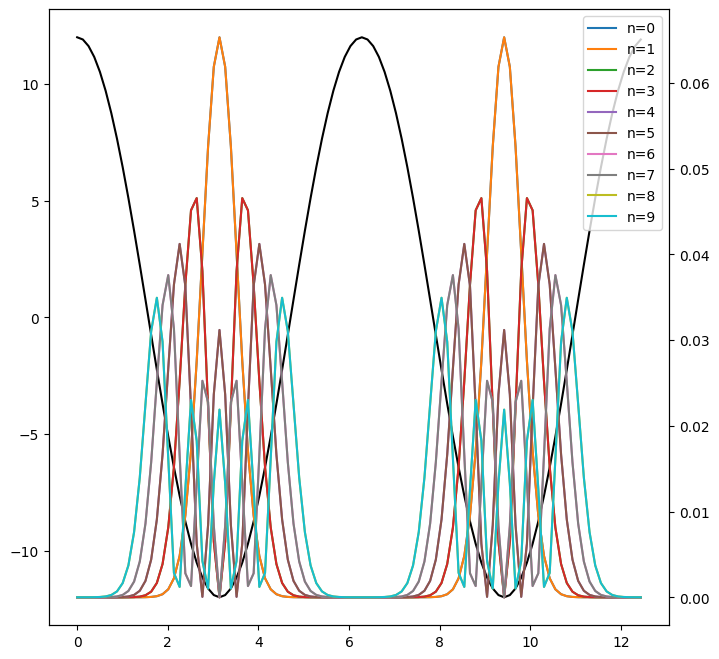

In [26]:
my_schroedinger = Schroedinger_1D_scipy(x_max=4*np.pi, n_states=16, scale=12)
my_schroedinger.solve()
my_schroedinger.plotDensity(0, 9)

从图中可以看出，两个原子之间（原子核在余弦函数两个最低谷对应的x位置）多数本征态对应的电荷密度 ($\Psi^2$) 都接近0, 尤其是低能态. 

即使我们把原子拉近，这些低能态还是不会相互作用，它们代表的是“芯部”电子，与原子核绑定，不参与形成化学键（几乎不贡献原子间共享的电荷）

电子数量增加到24，其他的不变。高能态将与原子结构更加无关，这些电子可以自由移动，就像金属体系那样

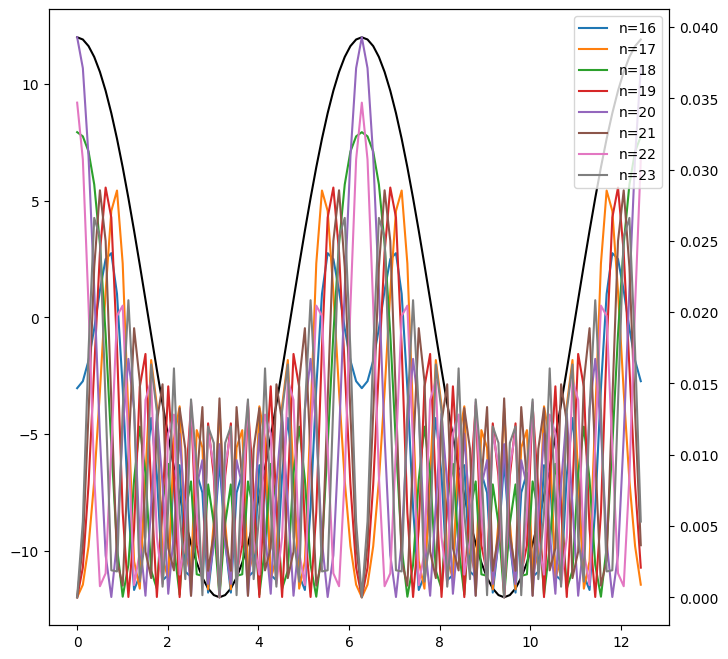

In [27]:
my_schroedinger = Schroedinger_1D_scipy(x_max=4*np.pi, n_states=24, scale=12)
my_schroedinger.solve()
my_schroedinger.plotDensity(16,24)

推广到二维

The other thing to remember is that the laplacian now has to be taken in 2 dimensions, so we need to "roll" $\Psi$ along both its x- and y-axes.

Below, `numpy.ravel()` is used to flatten a 2D array into a 1D array, and `numpy.reshape` is used to do the opposite.

We will switch to a sine wave potential centered at $\frac{\pi}{2}$ to show the 2D eigenvalues more clearly.

In [28]:
class Schroedinger_2D:
    def __init__(self, x_max=np.pi, resolution=100, potential=np.sin, scale=-20, n_states=5):
        self.resolution = resolution
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.xx, self.yy = np.meshgrid(self.x, self.x)
        self.potential = scale * potential(self.xx) * potential(self.yy)
        self.n_states = n_states
            
    def get_laplacian(self, psi): # -> 1d array
        psi = np.reshape(psi, (self.resolution, self.resolution))
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) +
                 np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) -
                 4 * psi) / self.dx**2).ravel()

    def get_hamiltonian(self, psi): # -> 1d array, 是个算符
        return -0.5 * self.get_laplacian(psi) + self.potential.ravel() * psi
    
    def solve(self):
        A = LinearOperator((self.resolution**2, self.resolution**2), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors.T

    def plot(self):
        fig, ax = plt.subplots(nrows=1, ncols=self.n_states, figsize=(15, 5))
        for i in range(self.n_states):
            ax[i].axis("off")
            ax[i].imshow(np.reshape(self.eigenvectors[i], (self.resolution, self.resolution)))
        plt.show()

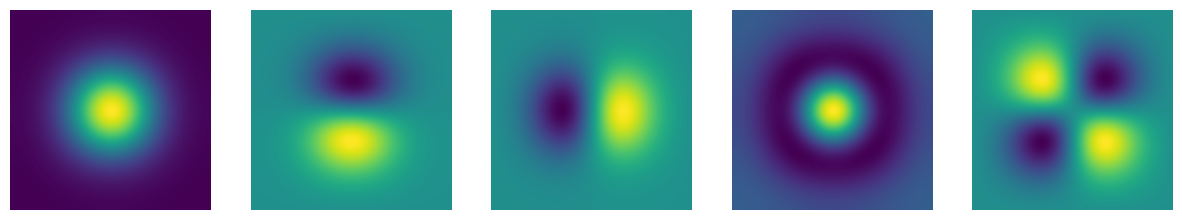

In [29]:
my_schroedinger = Schroedinger_2D()
my_schroedinger.solve()
my_schroedinger.plot()

已经可以看出 (1 $s$, 1 $p_x$ 1 $p_y$, 2 $s$, and 1 $d$) 原子轨道了。
之所以看不到 $p_z$ 是因为我们还没有考虑 $z$ 维度!

扩展到3D

In [30]:
from skimage.measure import marching_cubes

class Schroedinger_3D:
    def __init__(self, x_max=np.pi, resolution=20, potential=np.sin, scale=-30, n_states=8):
        self.resolution = resolution
        self.n_mat = resolution**3  # Stored as a variable to save us some computation
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.xx, self.yy, self.zz = np.meshgrid(self.x, self.x, self.x)
        self.potential = scale * potential(self.xx) * potential(self.yy) * potential(self.zz)
        self.n_states = n_states
        
    def get_laplacian(self, psi):
        psi = np.reshape(psi, (self.resolution, self.resolution, self.resolution))
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) +
                 np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) +
                 np.roll(psi, 1, axis=2) + np.roll(psi, -1, axis=2) +
                - 6 * psi)/self.dx**2).ravel()        
    
    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential.ravel() * psi
    
    def solve(self):
        A = LinearOperator((self.n_mat, self.n_mat), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = [np.reshape(ev, (self.resolution, self.resolution, self.resolution))
                             for ev in eigenvectors.T]
        
    def plot(self):
        fig = plt.figure(figsize=(20, 20/self.n_states))
        for i in range(self.n_states):
            v = self.eigenvectors[i]
            ax = fig.add_subplot(1, self.n_states, i+1, projection='3d')
            ax.axis("off")
            if i == 0: # i.e. there are no negative values
                verts, faces, normals, values = marching_cubes(v, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
            else:
                level1, level2 = max(v.ravel())*0.2, min(v.ravel())*0.2                
                verts, faces, normals, values = marching_cubes(v, level=level1, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
                verts, faces, normals, values = marching_cubes(v, level=level2, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
        plt.show()

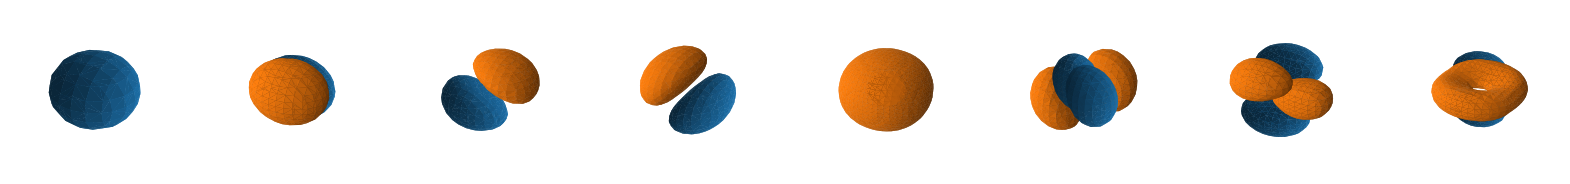

In [31]:
my_schroedinger = Schroedinger_3D()
my_schroedinger.solve()
my_schroedinger.plot()

上面求解的是无相互作用的单电子方程（即使有很多个电子，但是它们没有相互作用）

！不同原子轨道的波函数必定正交，这是由于薛定谔方程是线性方程，每个原子轨道对应的都是薛定谔方程的一个本征矢量，它们彼此正交，组成一个基底，任意线性组合得到的新的波函数也必然是薛定谔方程的解

$$\hat{H}_{ks}(r)\psi_i(r) = \epsilon_i\psi_i(r)$$

KS方程和普通薛定谔方程相似

$$\hat{H}_{ks}(r) = -\frac{1}{2}\nabla^2 + \nu_{eff}(r)$$
    
唯一的区别在于 $\nu_{pot}$ 替换成了等效势 $\nu_{eff}(r)$


$$\nu_{eff}(r) = \nu_{ext}(r) + \nu_{H}(r) + \nu_{xc}(r)$$

仔细看看这三个势场项：

- $\nu_{ext}(r)$ 外势, 与带正电的原子核相关:

$$\nu_{ext}(r) = \sum_i^N{\frac{Z_i}{|r-R_i|}}$$

- $\nu_{H}(r)$ Hartree势，或者库伦势：

$$\nu_{H}(r) = q^2\int{d^3r^\prime\frac{\rho(r^\prime)}{|r-r^\prime|}}$$
    
- $\nu_{xc}(r)$ 交换关联势，最有名的是LDA（与密度相关）和GGA（增加考虑了密度梯度）近似
    
$$\nu_{xc}(r) = \frac{\delta\epsilon^{hom}_{xc}(\rho(r))}{\delta~\rho(r)}$$

自洽求解，猜测密度分布，迭代直到收敛
    
$$E_{ks} = \sum_{i=1}^{N}{\epsilon_i} + \int{\nu_{ext}(r)\rho(r)dr} + \int{\nu_{H}(r)\rho(r)dr} + \int{\nu_{xc}(r)\rho(r)dr}$$

猜测的准确度大幅影响收敛速度。实际上，绝大多数程序都选用电中性、无相互作用的原子的重叠密度（overlapping densities）。这个重叠密度一般写在赝势文件上。

赝势将芯部电子与原子核绑定以提高计算效率，读取赝势文件，一般可以获得：
- 外势
- 起始电荷密度猜测值

我们先写一个类，从赝势文件中获取我们所需的**上述两个信息**

In [32]:
import os
from pseudo_dojo.core.pseudos import Pseudo
from pseudo_dojo.ppcodes.oncvpsp import OncvOutputParser
from scipy.interpolate import InterpolatedUnivariateSpline

class Pseudopotential:
    def __init__(self, element, prefix="ONCVPSP-PBE-PDv0.4/"):
        filename = os.path.join(prefix, element, "%s.psp8" % element)
        if not os.path.isfile(filename):
            filename = os.path.join(prefix, element, "%s-s.psp8" % element)
        if not os.path.isfile(filename):
            filename = os.path.join(prefix, element, "%s-sp.psp8" % element)
        self.pseudo = Pseudo.from_file(filename)
        self.scanner = OncvOutputParser(filename.replace(".psp8", ".out"))
        self.scanner.scan()

        self.filename = filename
        self.potentials = self.scanner.potentials
        self.densities = self.scanner.densities
        self.Z = self.pseudo.Z
        self.n_electrons = self.pseudo.Z_val
        self.r_cut = max(self.scanner.densities["rhoV"].rmesh)

        # 朝着反方向补齐
        mirrored_mesh = np.append(np.flip(-self.scanner.densities["rhoV"].rmesh), self.scanner.densities["rhoV"].rmesh)
        mirrored_values = np.append(np.flip(self.scanner.densities["rhoV"].values), self.scanner.densities["rhoV"].values)
        # 创建一个插值函数模板（后续调用它在新的点上估值）
        self.spline_density = InterpolatedUnivariateSpline(mirrored_mesh, mirrored_values)

line:  # lloc, lpopt,  rc(5),   dvloc0 
rc line:  4    5   0.70000      0.00000


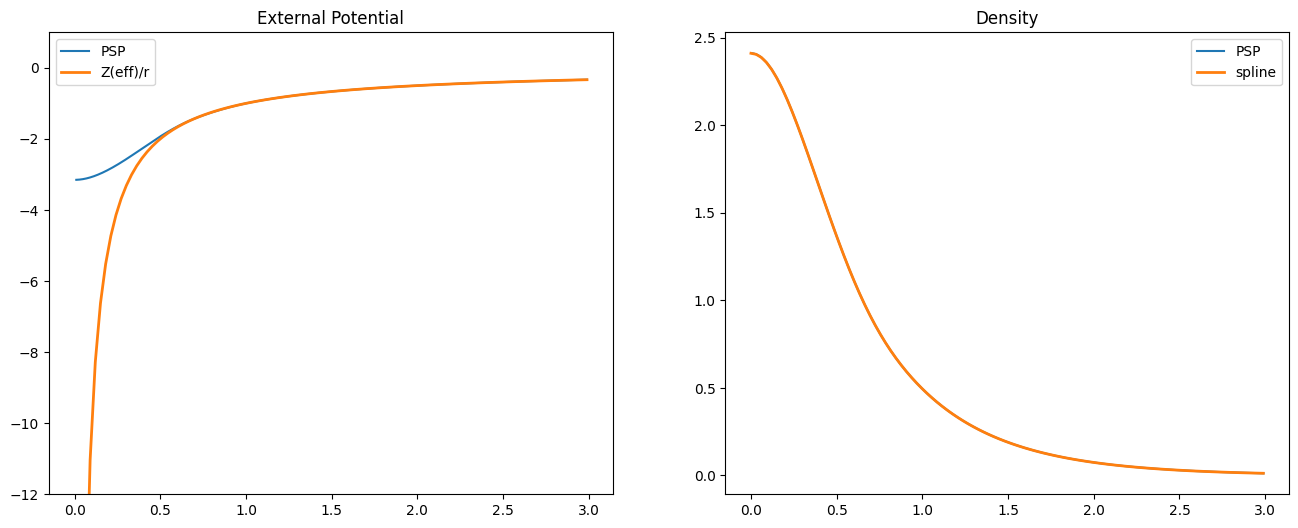

In [33]:
psp = Pseudopotential("H")
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("External Potential")
ax[0].plot(psp.potentials[-1].rmesh, psp.potentials[-1].values, label="PSP")
x = np.linspace(1e-6, max(psp.potentials[-1].rmesh), 100)
ax[0].plot(x, -psp.n_electrons / x, label="Z(eff)/r", linewidth=2)
ax[0].set_ylim(-12, 1)
ax[0].legend()

ax[1].set_title("Density")
ax[1].plot(psp.densities["rhoV"].rmesh, psp.densities["rhoV"].values, label="PSP")
ax[1].plot(x, psp.spline_density(x), linewidth=2, label="spline")
ax[1].legend()
plt.show()

在使用赝势之前，先得写一个DFT通用计算类：

In [34]:
from scipy.spatial.distance import cdist

class DFT:
    def __init__(self, resolution=(10, 10, 10), x_max=10, y_max=10, z_max=10, atoms=None, max_steps=150, convergence_threshold=1e-4, alpha_mix=0.2):
        """ A real-space Kohn-Sham equation solver for cubic cells """

        self.resolution = resolution
        self.x, self.dx = np.linspace(0, x_max, resolution[0], endpoint=False, retstep=True)
        self.y, self.dy = np.linspace(0, y_max, resolution[1], endpoint=False, retstep=True)
        self.z, self.dz = np.linspace(0, z_max, resolution[2], endpoint=False, retstep=True)
        self.omega = x_max * y_max * z_max
        self.n_mat = np.prod(resolution)
        self.xx, self.yy, self.zz = np.meshgrid(self.x, self.y, self.z)
        self.flat_mesh = np.array(list(zip(self.xx.ravel(), self.yy.ravel(), self.zz.ravel())))

        # dm means distance matrix
        dm = cdist(self.flat_mesh, self.flat_mesh)
        # Remove diagonal from dm
        self.dm = dm[~np.eye(dm.shape[0],dtype=bool)].reshape(dm.shape[0],-1)

        # 变量初始化
        self.E = 0
        self.v_H = np.zeros(self.resolution)
        self.v_xc = np.zeros(self.resolution)
        self.eigenvectors, self.eigenvalues = None, None
        self.max_steps = max_steps
        self.convergence_threshold = convergence_threshold
        self.alpha_mix = alpha_mix
        self.atoms = atoms
        self.n_atoms = np.sum([len(self.atoms[atom]) for atom in self.atoms])
        self.coords = []
        self.Zs = []
        for element in self.atoms:
            for coord in self.atoms[element]:
                self.coords.append(coord)
                self.Zs.append(Pseudopotential(element).Z)
        self.nn_coulomb_E = 0
        for i in range(len(self.coords)):
            for j in range(len(self.coords)):
                if i != j:
                    Rij = np.linalg.norm(np.subtract(self.coords[i], self.coords[j]))
                    self.nn_coulomb_E += 0.5 * self.Zs[i]*self.Zs[j] / Rij
        self.n_electrons = 0
        self.rho = np.zeros(self.n_mat)
        self.v_ext = np.zeros(self.n_mat)
        # 赋值
        self.initialize_pseudopotentials()
        
    def initialize_pseudopotentials(self):
        # ! 从赝势文件中初始化电荷密度和外势
        # 遍历所有原子（元素+坐标）
        for element in self.atoms:
            pseudopotential = Pseudopotential(element)
            for coords in self.atoms[element]:                
                distance_matrix_en = np.array([np.linalg.norm(pt-coords) for pt in self.flat_mesh])
                
                # 初始化格点上的密度
                density = pseudopotential.spline_density(distance_matrix_en)
                # 超过赝势截断半径的部分，电荷密度为0
                beyond_cutoff = distance_matrix_en > pseudopotential.r_cut
                density[beyond_cutoff] = 0
                # 归一化电荷密度
                norm = np.sum(density * self.omega/len(self.flat_mesh)) / pseudopotential.n_electrons
                self.rho += density / norm
                
                ### [-1] means only the "local" part, i.e. no difference for
                ### varying angular momentum (l)! If you want that then loop over [l].
                potential = pseudopotential.potentials[-1].spline(distance_matrix_en)
                # 超出截断半径的部分，势能适当修正（随距离单调递增 -> 与距离成反比）
                beyond_cutoff = distance_matrix_en > pseudopotential.r_cut
                all_electron = np.divide(-pseudopotential.n_electrons, distance_matrix_en[beyond_cutoff])
                potential[beyond_cutoff] = all_electron
                self.v_ext += potential

                self.n_electrons += int(pseudopotential.n_electrons)
        self.rho = self.rho.reshape(self.resolution)
        self.v_ext = self.v_ext.reshape(self.resolution)
                
    def update_rho(self):
        """
        Update charge density based on previous wavefunctions.
        
        Charge mixing is controlled by alpha_mixing. 
        """
        
        new_rho = np.zeros(self.resolution)
        for n in range(self.n_electrons):
            new_rho += np.power(self.eigenvectors[n], 2)
        old_rho = self.rho
        # Linear mixing:
        self.rho = self.alpha_mix * new_rho + (1-self.alpha_mix) * old_rho
        
    def update_v_H(self):
        """
        Update hartree potential based on charge density.
        """
        
        v_H = np.zeros(self.n_mat)
        rho = self.rho.ravel()
        for i in range(self.n_mat):
            v_H[i] += 0.5 * np.sum(np.delete(rho, i) / self.dm[i])
        self.v_H = v_H.reshape(self.resolution)
        del v_H
        
    def update_v_xc(self):
        """
        PASS
        """

        self.v_xc = np.zeros(self.resolution)
        # self.v_xc = np.ones(self.resolution)

    def update_v_all(self):
        self.update_v_H()
        self.update_v_xc()
        # v_ext doesn't update since we have no ionic steps.

    def get_laplacian(self, psi):
        psi = np.reshape(psi, self.resolution)
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) - 2 * psi)/self.dx**2 +
                (np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) - 2 * psi)/self.dy**2 +
                (np.roll(psi, 1, axis=2) + np.roll(psi, -1, axis=2) - 2 * psi)/self.dz**2).ravel()
        
    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + (self.v_ext.ravel() + self.v_H.ravel() + self.v_xc.ravel()) * psi

    def update_wavefunctions(self):
        A = LinearOperator((self.n_mat, self.n_mat), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_electrons)
        self.eigenvalues = eigenvalues
        self.eigenvectors = [np.reshape(ev, self.resolution) for ev in eigenvectors.T]

    def get_kinetic_energy(self):
        ke = 0
        for eigenvector in self.eigenvectors:
            ke -= np.sum(self.get_laplacian(eigenvector))
        return ke
            
    def get_ext_energy(self):
        return np.sum(self.rho.ravel() * self.v_ext.ravel())

    def get_coulomb_energy(self):
        return
    
    def get_hartree_energy(self):
        return np.sum(self.rho.ravel() * self.v_H.ravel())
        
    def get_xc_energy(self):
        return -0.75 * np.power(3./np.pi, 1./3.) * np.sum(np.power(self.rho, 4./3.))
        
    def update_energy(self):
        self.E = np.sum(self.eigenvalues) + self.nn_coulomb_E
        #self.E = self.get_kinetic_energy() + self.get_ext_energy() + self.get_hartree_energy() + self.nn_coulomb_E
        
    def sc_minimize(self, verbose=False):
        self.update_v_all()
        if verbose:
            print("n      E       dE    # e-")
        self.steps, self.delta_Es = [], []
        for i in range(self.max_steps):
            previous_E = self.E
            self.update_wavefunctions()
            self.update_rho()
            self.update_v_all()
            self.update_energy()
            self.steps.append(i)
            delta_E = self.E - previous_E
            
            n_same = 0
            for prev_delta in self.delta_Es:
                if abs(abs(delta_E) - abs(prev_delta)) < 1e-6:
                    n_same +=1
            if n_same > 4:
                print("Charge appears to be sloshing. Try lowering alpha_mixing")
                break
            self.delta_Es.append(delta_E)
            if verbose:
                print(
                    i+1,
                    round(self.E, 6),
                    round(delta_E, 6),
                    round(np.sum(self.rho * self.omega/len(self.flat_mesh)), 6)
                )
            if abs(delta_E) < self.convergence_threshold:
                self.converged = True
                break
        else:
            self.converged = False
            print(f"WARNING: Convergence ({self.convergence_threshold}) was never reached.")
            
    def plot_rho(self, iso):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.axis("off")
        verts, faces, normals, values = marching_cubes(self.rho, level=iso, spacing=(0.1, 0.1, 0.1))
        ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
        plt.show()
        
    def plot_rho2d(self):
        ax = plt.figure(figsize=(8, 8)).gca()
        ax.imshow(self.rho[int(len(self.rho)/2)])
        plt.show()
    
    def plot_rho1d(self, comparison_element="H", center=(5, 5, 5)):
        ax = plt.figure(figsize=(8, 8)).gca()
        radii = [np.linalg.norm(pt-center) for pt in self.flat_mesh]
        densities = [d for _,d in sorted(zip(radii,self.rho.ravel()))]
        radii.sort()
        psp = Pseudopotential(comparison_element)
        ax.plot(psp.densities["rhoV"].rmesh, psp.densities["rhoV"].values, label="PSP")
        ax.vlines(psp.r_cut, ymin=-1, ymax=1, color="black", linestyle="--")
        ax.plot(radii, densities, label="DFT")
        ax.legend()

line:  # lloc, lpopt,  rc(5),   dvloc0 
rc line:  4    5   0.70000      0.00000
line:  # lloc, lpopt,  rc(5),   dvloc0 
rc line:  4    5   0.70000      0.00000
line:  # lloc, lpopt,  rc(5),   dvloc0 
rc line:  4    5   0.70000      0.00000


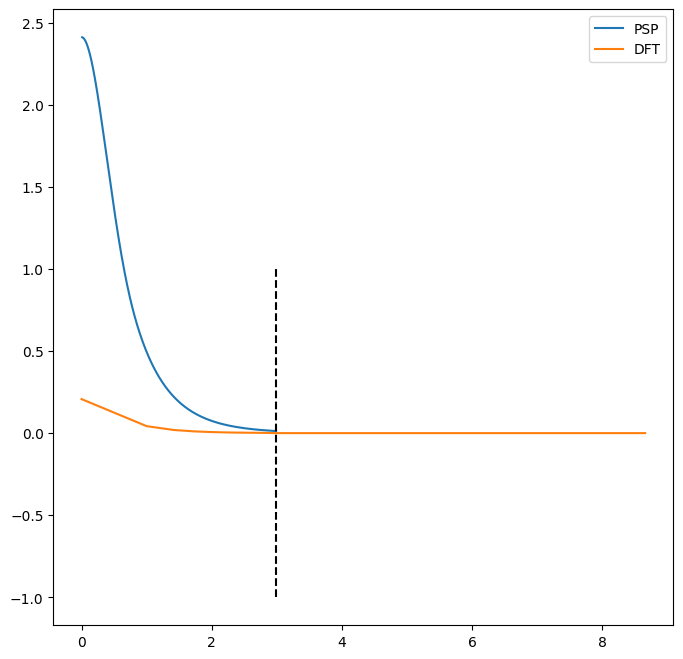

In [35]:
atoms = {"H": [(5, 5, 5)]}
pyrho = DFT(resolution=(10, 10, 10), x_max=10, y_max=10, z_max=10, atoms=atoms, max_steps=100, alpha_mix=0.5)
pyrho.plot_rho1d()

In [36]:
pyrho.sc_minimize(verbose=True)

n      E       dE    # e-
1 -0.62814 -0.62814 1.0
2 -0.652189 -0.024049 1.0
3 -0.667721 -0.015531 1.0
4 -0.677294 -0.009573 1.0
5 -0.683048 -0.005754 1.0
6 -0.686456 -0.003408 1.0
7 -0.688457 -0.002001 1.0
8 -0.689625 -0.001168 1.0
9 -0.690305 -0.000679 1.0
10 -0.690699 -0.000394 1.0
11 -0.690927 -0.000228 1.0
12 -0.691059 -0.000132 1.0
13 -0.691135 -7.6e-05 1.0


line:  # lloc, lpopt,  rc(5),   dvloc0 
rc line:  4    5   0.70000      0.00000


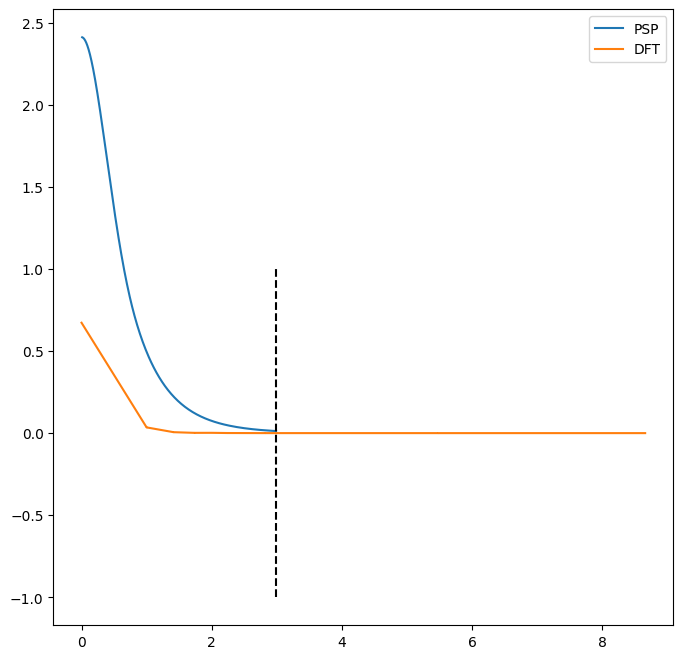

In [37]:
pyrho.plot_rho1d()

附录：修正不合理的势

line:  # lloc, lpopt,  rc(5),   dvloc0 
rc line:  4    5   0.70000      0.00000


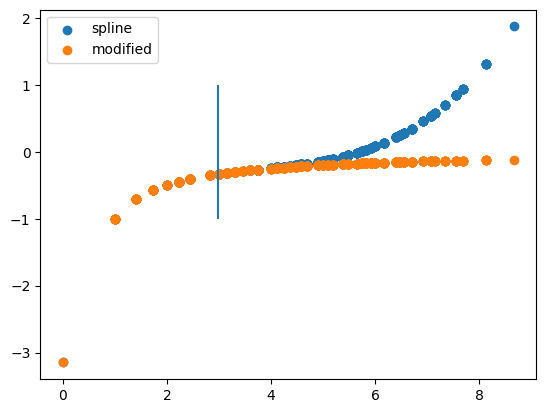

In [38]:
resolution = (10, 10, 10)
x_max, y_max, z_max = 10, 10, 10

x, dx = np.linspace(0, x_max, resolution[0], endpoint=False, retstep=True)
y, dy = np.linspace(0, y_max, resolution[1], endpoint=False, retstep=True)
z, dz = np.linspace(0, z_max, resolution[2], endpoint=False, retstep=True)
omega = x_max * y_max * z_max
n_mat = np.prod(resolution)
xx, yy, zz = np.meshgrid(x, y, z)
flat_mesh = np.array(list(zip(xx.ravel(), yy.ravel(), zz.ravel())))
rho = np.zeros(n_mat)
v_ext = np.zeros(n_mat)
n_electrons = 0

pseudopotential = Pseudopotential('H')
coords = [5, 5, 5]          
distance_matrix_en = np.array([np.linalg.norm(pt-coords) for pt in flat_mesh])

# 初始化格点上的密度
density = pseudopotential.spline_density(distance_matrix_en)
# 超过赝势截断半径的部分，电荷密度为0
beyond_cutoff = distance_matrix_en > pseudopotential.r_cut
density[beyond_cutoff] = 0
# 归一化电荷密度
norm = np.sum(density * omega/len(flat_mesh)) / pseudopotential.n_electrons
rho += density / norm

### [-1] means only the "local" part, i.e. no difference for
### varying angular momentum (l)! If you want that then loop over [l].
potential = pseudopotential.potentials[-1].spline(distance_matrix_en)
plt.scatter(distance_matrix_en, potential,label='spline')
plt.vlines(pseudopotential.r_cut, -1, 1) # r_cut
beyond_cutoff = distance_matrix_en > pseudopotential.r_cut
all_electron = np.divide(-pseudopotential.n_electrons, distance_matrix_en[beyond_cutoff])
potential[beyond_cutoff] = all_electron
plt.scatter(distance_matrix_en, potential,label='modified')
plt.legend()

v_ext += potential
n_electrons += int(pseudopotential.n_electrons)